In [1]:
import sys, os, re, csv, codecs 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt, seaborn as sns
import string
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords 
nltk.download('stopwords')

import keras

[nltk_data] Downloading package stopwords to C:\Users\Jordan
[nltk_data]     Fan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [2]:
path = "./input/"
embedding_file = f'{path}glove.6B.50d.txt'
train_file = f'{path}train.csv'
test_file = f'{path}test.csv'

In [3]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
train.shape

(159571, 8)

In [4]:
text = pd.DataFrame(train["comment_text"])
toxic = pd.DataFrame(train["toxic"])
severe_toxic = pd.DataFrame(train["severe_toxic"])
obscene_toxic = pd.DataFrame(train["obscene"])
threat = pd.DataFrame(train["obscene"])
insult = pd.DataFrame(train["insult"])
identity_hate = pd.DataFrame(train["identity_hate"])
text.head()

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


### Checking if there are any null values

In [5]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


### Comment Cleaning 

In [6]:
eng_stopwords = set(stopwords.words('english'))

In [12]:

text["comment_text"] = text["comment_text"].str.lower()
#gets rid of punctuations 
#text["no_punc"] = text["comment_text"].str.replace("[^\w\s]", " ").str.replace("\s", " ").str.replace("\s+", " ").str.strip()
#number of sentences in the text
text["count_sent"] = text["comment_text"].apply(lambda x: len(re.findall("\n", str(x))) + 1)
#number of words in the text
text["count_word"] = text["comment_text"].apply(lambda x: len(str(x).split()))
#number of unique words in the text
text["count_unique_word"] = text["comment_text"].apply(lambda x: len(set(str(x).split())))
#character count 
text["count_char"] = text["comment_text"].apply(lambda x: len(str(x)))
#counts the number of punctuations
text["count_punctuations"] = text["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
text["count_words_upper"] = text["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
text["count_words_title"] = text["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
text["count_stopwords"] = text["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
text["mean_word_len"] = text["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
text.head()

,comment_text,count_sent,count_word,count_unique_word,count_char,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,explanation\nwhy the edits made under my usern...,2,43,41,264,10,0,0,18,5.162791
1,d'aww! he matches this background colour i'm s...,1,17,17,112,12,0,0,2,5.588235
2,"hey man, i'm really not trying to edit war. it...",1,42,39,233,6,0,0,20,4.571429
3,"""\nmore\ni can't make any real suggestions on ...",5,113,81,622,21,0,0,56,4.486726
4,"you, sir, are my hero. any chance you remember...",1,13,13,67,5,0,0,5,4.230769


### Subsetting data to include rows that are labeled with a tag

In [15]:
toxic = train[(train["toxic"] != 0) | (train["severe_toxic"] != 0) | 
              (train["obscene"] != 0) | (train["threat"] != 0) | 
              (train["insult"] != 0) | (train["identity_hate"] != 0)]

### 

In [7]:
#counts = []
#for i in objects:
#    counts += toxic[toxic[i] == 1].shape[0]
objects = list(toxic.columns[2:8])
y_pos = np.arange(len(objects))
counts = []
for i in objects:
    counts.append(toxic[toxic[i] == 1].shape[0])
counts

[]

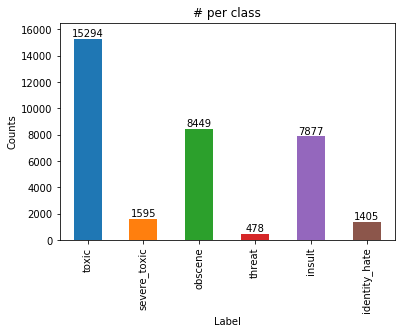

In [95]:
objects = list(toxic.columns[2:8])
y_pos = np.arange(len(objects))
counts = []
for i in objects:
    counts.append(toxic[toxic[i] == 1].shape[0])

ax = pd.Series.from_array(counts).plot(kind = "bar")
#ax.xticklabel(y_pos)
#ax.ylabel('# of Occurences')
ax.set_title('# per class')
ax.set_xlabel("Label")
ax.set_ylabel("Counts")
ax.set_xticklabels(objects)
ax.set_ylim(0, 16500)
for rect, label in zip(ax.patches, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha = "center", va = "bottom")


In [96]:
toxic.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.081465,-0.020260,-0.002464,-0.042957,-0.021089
severe_toxic,0.081465,1.000000,0.284441,0.079589,0.247133,0.128725
obscene,-0.020260,0.284441,1.000000,0.038003,0.506815,0.131760
threat,-0.002464,0.079589,0.038003,1.000000,0.054652,0.073364
insult,-0.042957,0.247133,0.506815,0.054652,1.000000,0.209547
identity_hate,-0.021089,0.128725,0.131760,0.073364,0.209547,1.000000
